https://towardsdatascience.com/the-complete-guide-to-time-series-forecasting-using-sklearn-pandas-and-numpy-7694c90e45c1

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
data = sm.datasets.co2.load_pandas().data
data.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [12]:
len(data)

2284

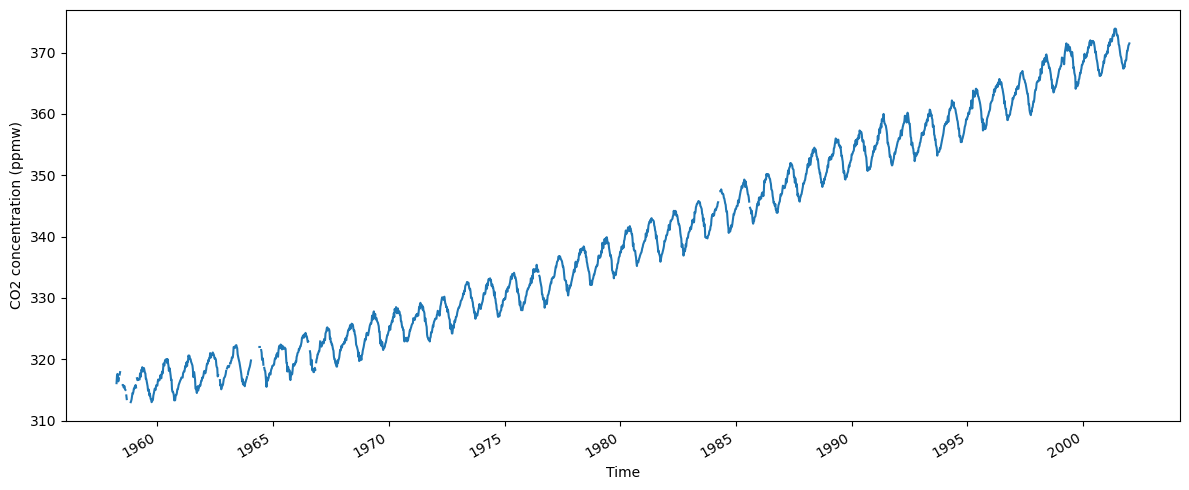

In [7]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(data['co2'])
ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmw)')

fig.autofmt_xdate()
plt.tight_layout()

In [8]:
data = data.interpolate()

In [9]:
df = data.copy()
df['y'] = df['co2'].shift(-1)
df.head()

,co2,y
1958-03-29,316.1,317.3
1958-04-05,317.3,317.6
1958-04-12,317.6,317.5
1958-04-19,317.5,316.4
1958-04-26,316.4,316.9


In [13]:
train = df[:-104]
test = df[-104:]
test = test.drop(test.tail(1).index)

In [15]:
test = test.copy()
test['baseline_pred'] = test['co2']
test.head()

,co2,y,baseline_pred
2000-01-08,368.5,369.0,368.5
2000-01-15,369.0,369.8,369.0
2000-01-22,369.8,369.2,369.8
2000-01-29,369.2,369.1,369.2
2000-02-05,369.1,369.6,369.1


In [17]:
from sklearn.tree import DecisionTreeRegressor

X_train = train['co2'].values.reshape(-1,1)
Y_train = train['y'].values.reshape(-1,1)
X_test = test['co2'].values.reshape(-1,1)

# Initialise the model
dt_reg = DecisionTreeRegressor(random_state=42)

# Fit the model
dt_reg.fit(X_train,Y_train)

# Make predictions
dt_pred = dt_reg.predict(X_test)

# Assign predictions to a new column in test
test['dt_pred'] = dt_pred
test.head()

,co2,y,baseline_pred,dt_pred
2000-01-08,368.5,369.0,368.5,368.65
2000-01-15,369.0,369.8,369.0,368.50
2000-01-22,369.8,369.2,369.8,369.40
2000-01-29,369.2,369.1,369.2,369.10
2000-02-05,369.1,369.6,369.1,368.80


In [18]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, Y_train)
gbr_pred = gbr.predict(X_test)
test['gbr_pred'] = gbr_pred
test.head()

/Users/mcardonasanchez/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,co2,y,baseline_pred,dt_pred,gbr_pred
2000-01-08,368.5,369.0,368.5,368.65,368.556464
2000-01-15,369.0,369.8,369.0,368.50,368.774435
2000-01-22,369.8,369.2,369.8,369.40,369.512468
2000-01-29,369.2,369.1,369.2,369.10,369.041813
2000-02-05,369.1,369.6,369.1,368.80,368.774435


In [19]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true))*100,2)


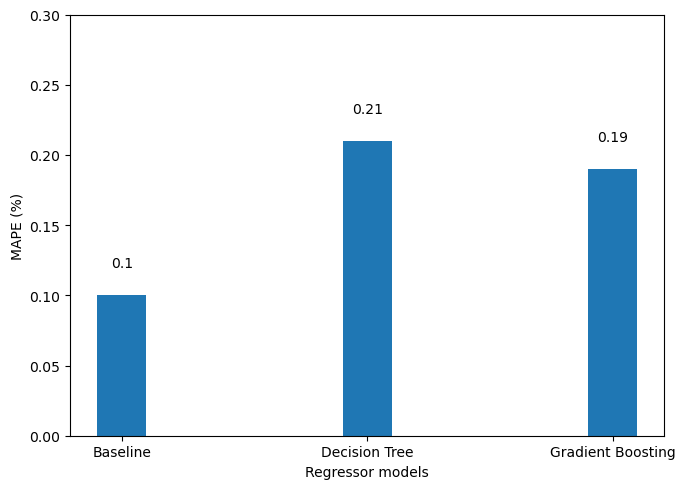

In [24]:
baseline_mape = mape(test['y'], test['baseline_pred'])
dt_mape = mape(test['y'], test['dt_pred'])
gbr_mape = mape(test['y'], test['gbr_pred'])

# Generate bar plot
fig, ax = plt.subplots(figsize=(7,5))

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_mape, gbr_mape]

ax.bar(x, y, width=0.2)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 0.3)


for index, value in enumerate(y):
    plt.text(x=index, y=value+0.02, s=str(value), ha='center')

plt.tight_layout() 

In [25]:
def window_input(window_length: int, data: pd.DataFrame) -> pd.DataFrame:

    df = data.copy()
    i = 1
    while i < window_length:
        df[f'x_{i}'] = df['co2'].shift(-i)
        i+=1
    if i == window_length:
        df['y'] = df['co2'].shift(-i)
    
    # Drop rows where there is a NaN
    df = df.dropna(axis=0)

    return df

In [28]:
new_df = window_input(5,data)
new_df.head(10)

,co2,x_1,x_2,x_3,x_4,y
1958-03-29,316.10,317.30,317.60,317.50,316.40,316.90
1958-04-05,317.30,317.60,317.50,316.40,316.90,317.20
1958-04-12,317.60,317.50,316.40,316.90,317.20,317.50
1958-04-19,317.50,316.40,316.90,317.20,317.50,317.90
1958-04-26,316.40,316.90,317.20,317.50,317.90,317.55
1958-05-03,316.90,317.20,317.50,317.90,317.55,317.20
1958-05-10,317.20,317.50,317.90,317.55,317.20,316.85
1958-05-17,317.50,317.90,317.55,317.20,316.85,316.50
1958-05-24,317.90,317.55,317.20,316.85,316.50,316.15
1958-05-31,317.55,317.20,316.85,316.50,316.15,315.80


In [30]:
from sklearn.model_selection import train_test_split

X = new_df[['co2', 'x_1', 'x_2', 'x_3', 'x_4']].values
y = new_df['y'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [31]:
baseline_pred = []

for row in X_test:
    baseline_pred.append(np.mean(row))

In [34]:
dt_reg_5 = DecisionTreeRegressor(random_state=42)
dt_reg_5.fit(X_train, y_train)
dt_reg_5_pred = dt_reg_5.predict(X_test)

In [35]:
gbr_5 = GradientBoostingRegressor(random_state=42)
gbr_5.fit(X_train, y_train.ravel())
gbr_5_pred = gbr_5.predict(X_test)

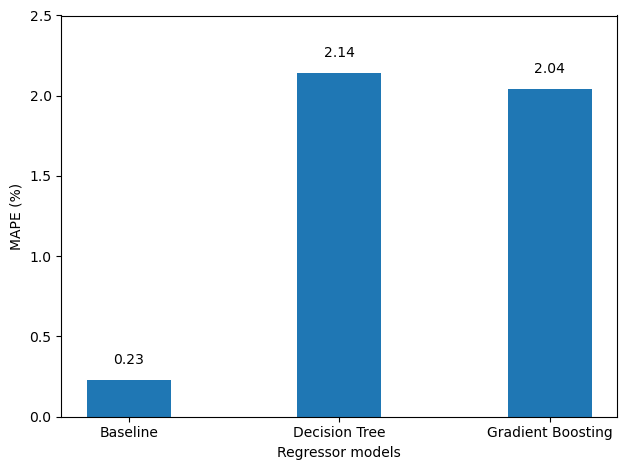

In [39]:
baseline_mape = mape(y_test, baseline_pred)
dt_5_mape = mape(y_test, dt_reg_5_pred)
gbr_5_mape = mape(y_test, gbr_5_pred)

# Generate the bar plot
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_5_mape, gbr_5_mape]

ax.bar(x,y, width =0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 2.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.1, s=str(value), ha='center')
    
plt.tight_layout()

In [42]:
def window_input_output(input_length: int, output_length: int, data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()

    i=1
    while i<input_length:
        df[f'x_{i}'] = df['co2'].shift(-i)
        i+=1

    j=0
    while j<output_length:
        df[f'y_{j}'] = df['co2'].shift(-output_length-j)
        j+=1

    df = df.dropna(axis=0)

    return df

In [47]:
seq_df = window_input_output(26, 26, data)
seq_df.head(5)

,co2,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,y_16,y_17,y_18,y_19,y_20,y_21,y_22,y_23,y_24,y_25
1958-03-29,316.1,317.3,317.6,317.5,316.4,316.90,317.20,317.50,317.90,317.55,...,315.60,315.80,315.40,316.15,316.90,316.60,316.60,316.80,316.75,316.7
1958-04-05,317.3,317.6,317.5,316.4,316.9,317.20,317.50,317.90,317.55,317.20,...,315.80,315.40,316.15,316.90,316.60,316.60,316.80,316.75,316.70,316.7
1958-04-12,317.6,317.5,316.4,316.9,317.2,317.50,317.90,317.55,317.20,316.85,...,315.40,316.15,316.90,316.60,316.60,316.80,316.75,316.70,316.70,317.7
1958-04-19,317.5,316.4,316.9,317.2,317.5,317.90,317.55,317.20,316.85,316.50,...,316.15,316.90,316.60,316.60,316.80,316.75,316.70,316.70,317.70,317.1
1958-04-26,316.4,316.9,317.2,317.5,317.9,317.55,317.20,316.85,316.50,316.15,...,316.90,316.60,316.60,316.80,316.75,316.70,316.70,317.70,317.10,317.6


In [49]:
X_cols = [col for col in seq_df.columns if col.startswith('x')]
X_cols.insert(0, 'co2')

y_cols = [col for col in seq_df.columns if col.startswith('y')]

X_train = seq_df[X_cols][:-2].values
y_train = seq_df[y_cols][:-2].values

X_test = seq_df[X_cols][-2:].values
y_test = seq_df[y_cols][-2:].values

2

In [50]:
dt_seq = DecisionTreeRegressor(random_state=42)
dt_seq.fit(X_train, y_train)
dt_seq_pred = dt_seq.predict(X_test)

In [51]:
from sklearn.multioutput import RegressorChain

gbr_seq = GradientBoostingRegressor(random_state=42)
chained_gbr = RegressorChain(gbr_seq)
chained_gbr.fit(X_train, y_train)
gbr_seq_pred = chained_gbr.predict(X_test)

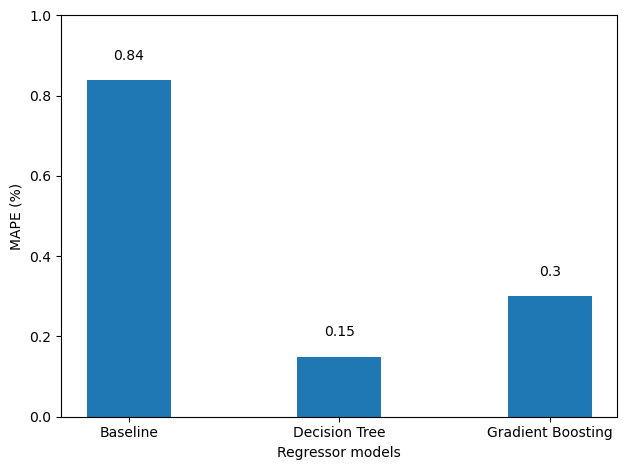

In [59]:
mape_dt_seq = mape(dt_seq_pred.reshape(1,-1), y_test.reshape(1,-1))
mape_gbr_seq = mape(gbr_seq_pred.reshape(1,-1), y_test.reshape(1,-1))
mape_baseline = mape(X_test.reshape(1,-1), y_test.reshape(1,-1))

# Generate the bar plot
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [mape_baseline, mape_dt_seq, mape_gbr_seq]

ax.bar(x,y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0,1)


for index, value in enumerate(y):
    plt.text(x=index, y=value+0.05, s=str(value), ha='center')

plt.tight_layout()

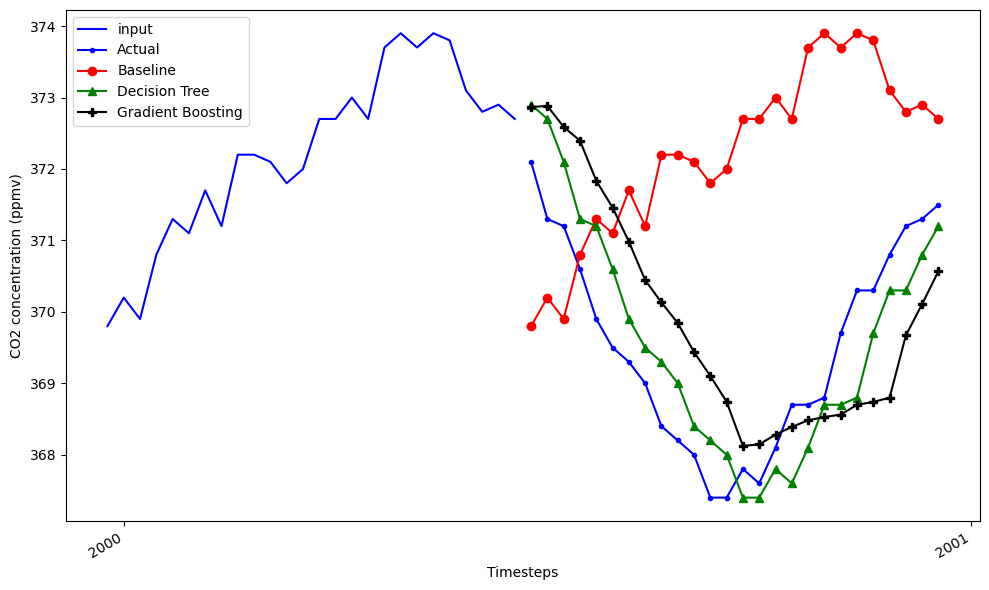

In [63]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(np.arange(0,26,1), X_test[1], 'b-', label='input')
ax.plot(np.arange(26,52,1), y_test[1], marker='.', color='blue', label='Actual')
ax.plot(np.arange(26, 52, 1), X_test[1], marker='o', color='red', label='Baseline')
ax.plot(np.arange(26, 52, 1), dt_seq_pred[1], marker='^', color='green', label='Decision Tree')
ax.plot(np.arange(26, 52, 1), gbr_seq_pred[1], marker='P', color='black', label='Gradient Boosting')
ax.set_xlabel('Timesteps')
ax.set_ylabel('CO2 concentration (ppmv)')
plt.xticks(np.arange(1, 104, 52), np.arange(2000, 2002, 1))
plt.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()